# MLP
MLP, K=5, lncRNA.

Droput.

In [23]:
from datetime import datetime
print(datetime.now())

2023-04-06 20:01:01.883663


In [24]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODELS_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODELS_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac

print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [25]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.optimizers import SGD
#from keras.losses import Hinge

K=3
ALPHABET=4**K + 1
RCELLS=32
DCELLS=16
EPOCHS=10 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000 # NOT USED FOR MLP
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [26]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [27]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [28]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN) # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # No MAXLEN for MLP
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [29]:
def build_model():
    CFILTERS=64   # 64 was overfitting 
    FILTERSIZE=8
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn    = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    dens_layer = Dense(32,activation='sigmoid')
    drop3_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop3_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [30]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 20:01:03.836876
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 4998, 4)           260       
                                                                 
 conv1d_18 (Conv1D)          (None, 4991, 64)          2112      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 1246, 64)          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 308, 64)          0         
 g1D)                      

## Training

In [31]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            print('Model saved to',MODELS_DIR,filename)
            self.model.save(MODELS_DIR+filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(MODELS_DIR+filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [32]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 20:01:04.061595
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 20:01:11.909651
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 20:01:11.928967
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 20:01:13.271281


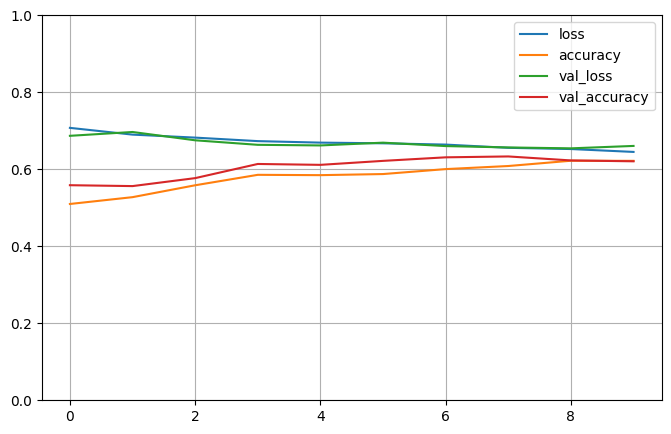

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.1.1.model



Testing # 1 1
2023-04-06 20:01:31.967496
2023-04-06 20:01:31.967539
PREDICT
2023-04-06 20:01:32.192324
Test 1:0 458:412 52.64%
Predict 1:0 666:204 76.55%
Test sizes (870, 4998) (870,)
Distrib of scores: 0.5623837 mean 0.14914922 std
Range of scores: 0.033800695 to 0.83084846
Score threshold 0.5
Confusion matrix
 [[143 269]
 [ 61 397]]
Normalized matrix
 [[0.16436782 0.3091954 ]
 [0.07011494 0.45632184]]
Correct scores pos:neg 187 63
Wrong scores pos:neg 84 30


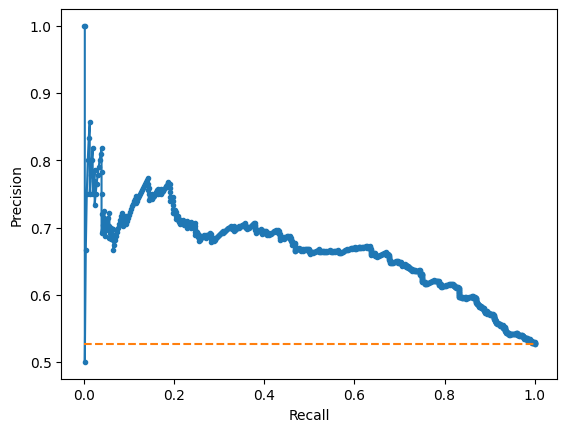

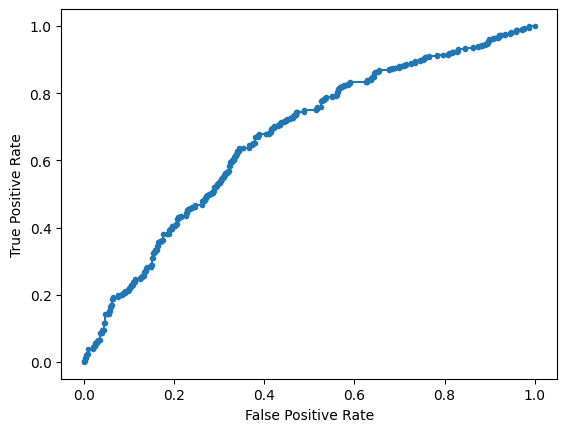

Accuracy: 62.07% Precision: 59.61% Recall: 86.68%
F1: 70.64% MCC: 0.2521
AUPRC: 66.57% AUROC: 67.01%
 accuracy [62.06896551724138]
 precision [59.60960960960961]
 recall [86.68122270742357]
 F1 [70.6405693950178]
 MCC [0.2520804310225378]
 AUPRC [66.56903582837442]
 AUROC [67.0109594268029]

Training # 1 2
2023-04-06 20:01:33.022759
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 20:01:33.041750
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 20:01:35.004666


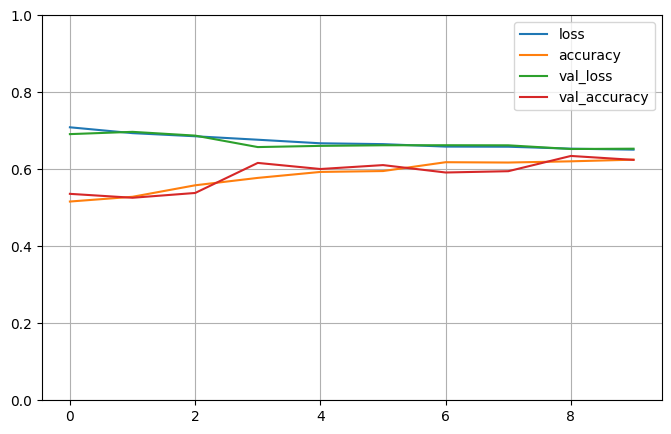

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.1.2.model



Testing # 1 2
2023-04-06 20:02:48.046381
2023-04-06 20:02:48.046425
PREDICT
2023-04-06 20:02:48.276022
Test 1:0 442:442 50.00%
Predict 1:0 490:394 55.43%
Test sizes (884, 4998) (884,)
Distrib of scores: 0.49166325 mean 0.12480316 std
Range of scores: 0.082135506 to 0.7189333
Score threshold 0.5
Confusion matrix
 [[252 190]
 [142 300]]
Normalized matrix
 [[0.28506787 0.21493213]
 [0.16063348 0.33936652]]
Correct scores pos:neg 53 95
Wrong scores pos:neg 25 48


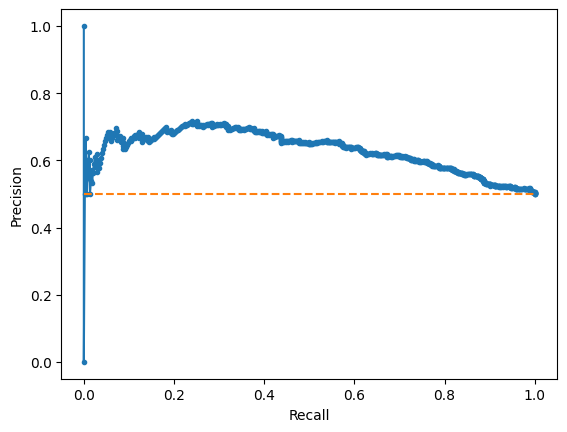

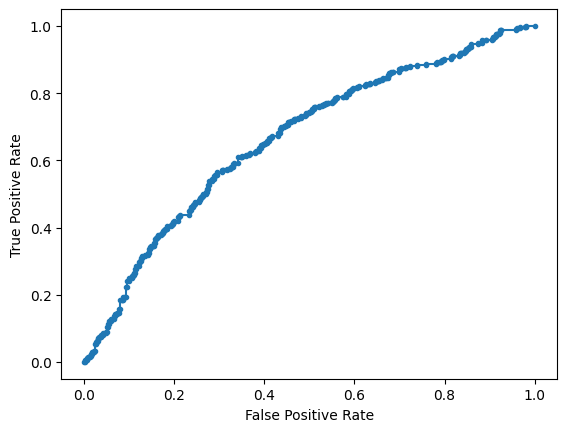

Accuracy: 62.44% Precision: 61.22% Recall: 67.87%
F1: 64.38% MCC: 0.2503
AUPRC: 62.96% AUROC: 66.45%
 accuracy [62.44343891402715]
 precision [61.224489795918366]
 recall [67.87330316742081]
 F1 [64.37768240343348]
 MCC [0.250349388094601]
 AUPRC [62.95913491924365]
 AUROC [66.44980651501812]

Training # 1 3
2023-04-06 20:02:49.244295
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 20:02:49.268769
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 20:02:51.440760


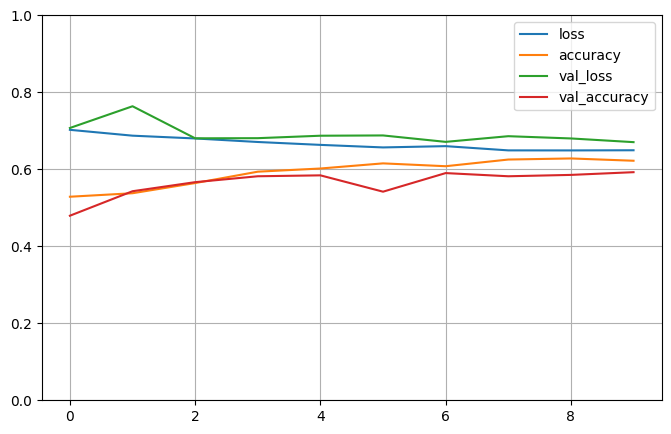

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.1.3.model



Testing # 1 3
2023-04-06 20:03:09.521202
2023-04-06 20:03:09.521243
PREDICT
2023-04-06 20:03:09.744031
Test 1:0 442:407 52.06%
Predict 1:0 550:299 64.78%
Test sizes (849, 4998) (849,)
Distrib of scores: 0.52990854 mean 0.14272876 std
Range of scores: 0.06347447 to 0.741512
Score threshold 0.5
Confusion matrix
 [[180 227]
 [119 323]]
Normalized matrix
 [[0.21201413 0.26737338]
 [0.1401649  0.38044759]]
Correct scores pos:neg 132 78
Wrong scores pos:neg 81 37


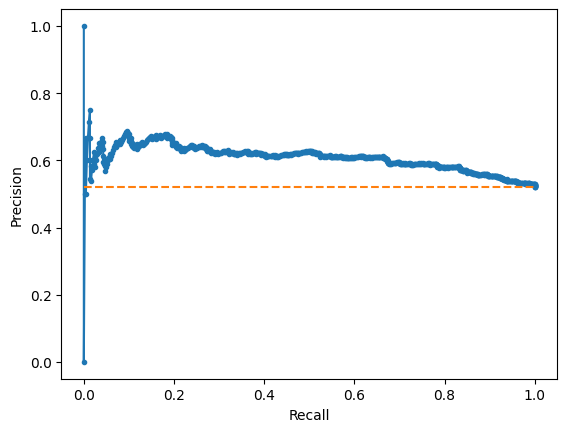

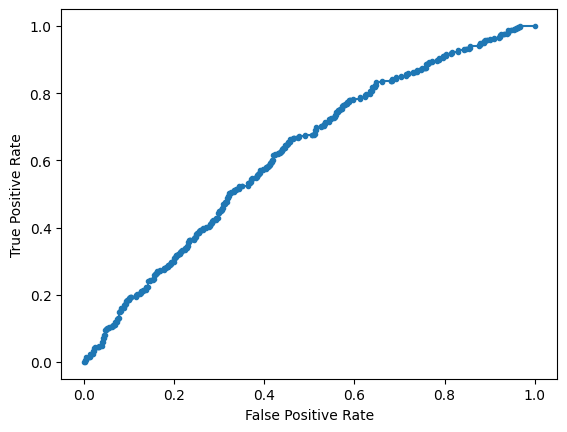

Accuracy: 59.25% Precision: 58.73% Recall: 73.08%
F1: 65.12% MCC: 0.1810
AUPRC: 60.71% AUROC: 62.03%
 accuracy [59.246171967020025]
 precision [58.72727272727273]
 recall [73.07692307692307]
 F1 [65.12096774193549]
 MCC [0.1809722506423339]
 AUPRC [60.71382555954419]
 AUROC [62.02930614695321]

Training # 1 4
2023-04-06 20:03:10.367372
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 20:03:10.392028
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 20:03:11.684262


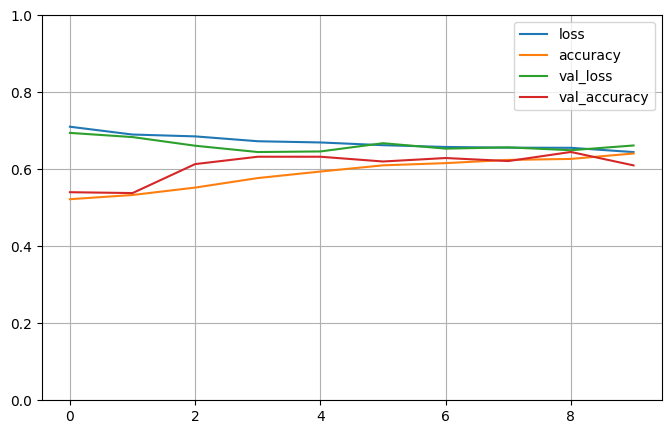

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.1.4.model



Testing # 1 4
2023-04-06 20:03:30.978166
2023-04-06 20:03:30.978212
PREDICT
2023-04-06 20:03:31.390472
Test 1:0 459:431 51.57%
Predict 1:0 390:500 43.82%
Test sizes (890, 4998) (890,)
Distrib of scores: 0.45830312 mean 0.16593969 std
Range of scores: 0.104689695 to 0.80598205
Score threshold 0.5
Confusion matrix
 [[292 139]
 [208 251]]
Normalized matrix
 [[0.32808989 0.15617978]
 [0.23370787 0.28202247]]
Correct scores pos:neg 109 189
Wrong scores pos:neg 44 98


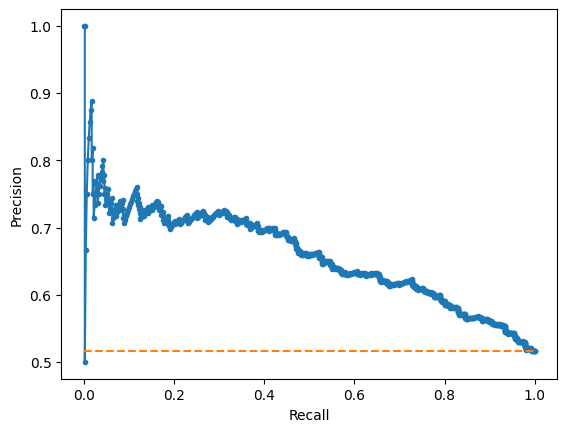

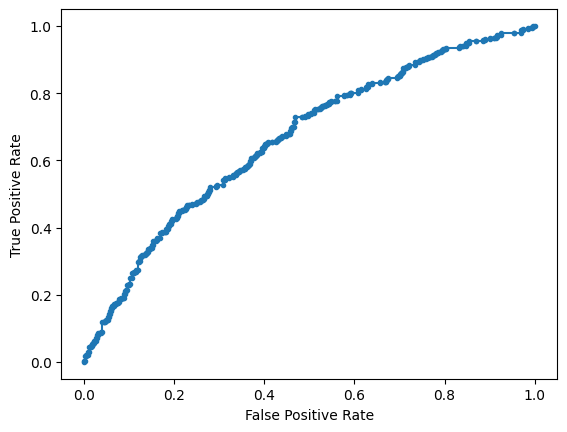

Accuracy: 61.01% Precision: 64.36% Recall: 54.68%
F1: 59.13% MCC: 0.2260
AUPRC: 65.74% AUROC: 66.32%
 accuracy [61.01123595505618]
 precision [64.35897435897436]
 recall [54.68409586056645]
 F1 [59.12838633686691]
 MCC [0.2259565912285312]
 AUPRC [65.74164929616163]
 AUROC [66.31585864559797]

Training # 1 5
2023-04-06 20:03:32.241862
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 20:03:32.262804
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 20:03:33.502237


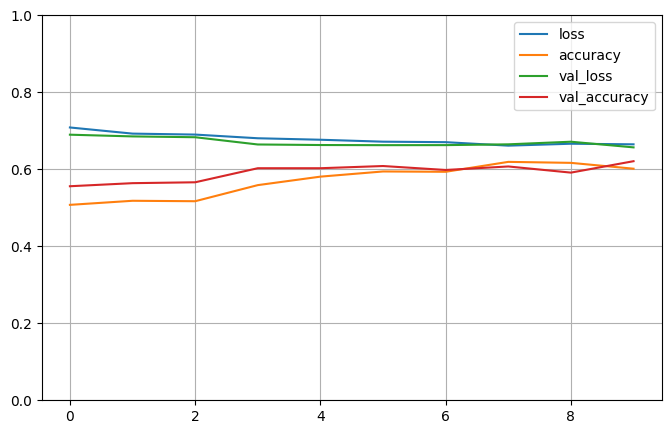

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.1.5.model



Testing # 1 5
2023-04-06 20:03:52.707996
2023-04-06 20:03:52.708039
PREDICT
2023-04-06 20:03:52.934899
Test 1:0 457:419 52.17%
Predict 1:0 599:277 68.38%
Test sizes (876, 4998) (876,)
Distrib of scores: 0.5376279 mean 0.12827545 std
Range of scores: 0.18951422 to 0.7106762
Score threshold 0.5
Confusion matrix
 [[182 237]
 [ 95 362]]
Normalized matrix
 [[0.20776256 0.27054795]
 [0.10844749 0.41324201]]
Correct scores pos:neg 124 77
Wrong scores pos:neg 58 28


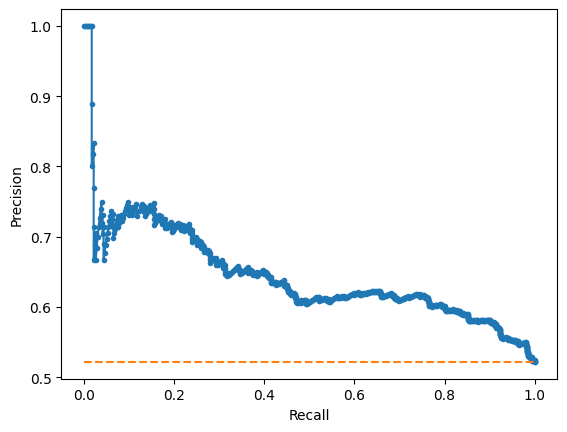

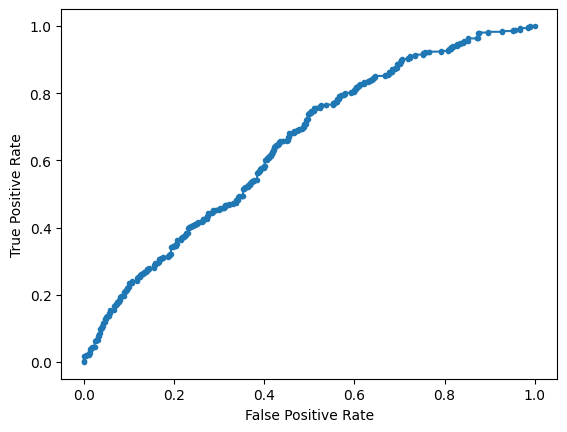

Accuracy: 62.10% Precision: 60.43% Recall: 79.21%
F1: 68.56% MCC: 0.2433
AUPRC: 64.51% AUROC: 64.61%
 accuracy [62.10045662100456]
 precision [60.434056761268785]
 recall [79.21225382932167]
 F1 [68.56060606060606]
 MCC [0.2433105839708835]
 AUPRC [64.50676070517683]
 AUROC [64.61278546920614]

Training # 2 1
2023-04-06 20:03:53.582359
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 20:03:54.419648
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 20:03:56.249108


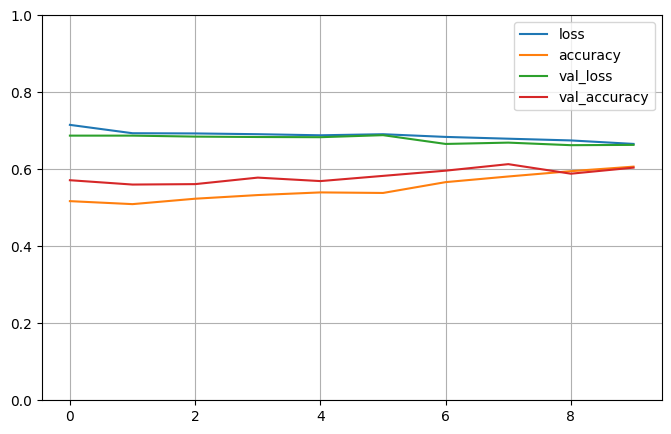

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.2.1.model



Testing # 2 1
2023-04-06 20:04:15.583373
2023-04-06 20:04:15.583431
PREDICT
2023-04-06 20:04:15.807342
Test 1:0 472:415 53.21%
Predict 1:0 557:330 62.80%
Test sizes (887, 4998) (887,)
Distrib of scores: 0.51575446 mean 0.08565468 std
Range of scores: 0.2785354 to 0.71953326
Score threshold 0.5
Confusion matrix
 [[197 218]
 [133 339]]
Normalized matrix
 [[0.22209696 0.24577227]
 [0.14994363 0.38218715]]
Correct scores pos:neg 19 32
Wrong scores pos:neg 6 13


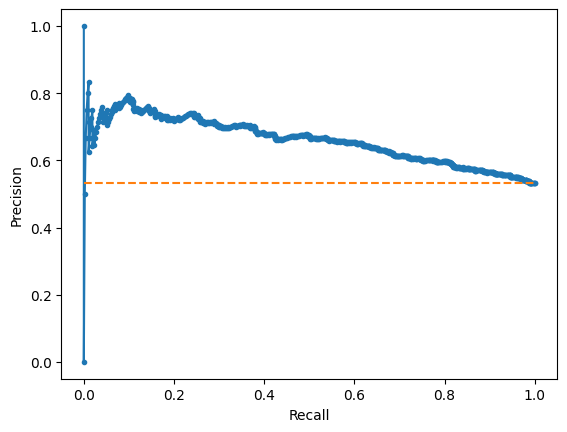

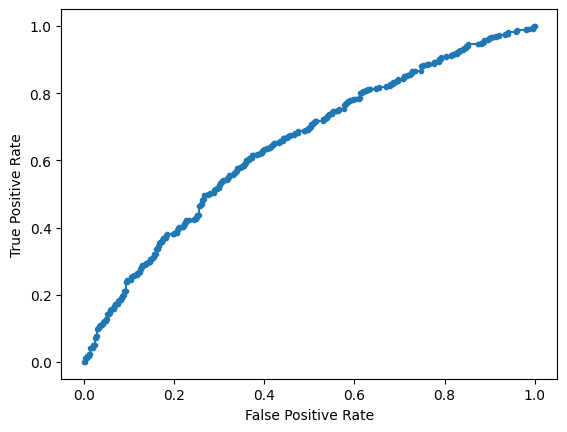

Accuracy: 60.43% Precision: 60.86% Recall: 71.82%
F1: 65.89% MCC: 0.1992
AUPRC: 65.84% AUROC: 64.82%
 accuracy [60.42841037204059]
 precision [60.86175942549371]
 recall [71.82203389830508]
 F1 [65.88921282798833]
 MCC [0.1991525099468546]
 AUPRC [65.83994893003693]
 AUROC [64.81621400857668]

Training # 2 2
2023-04-06 20:04:16.455986
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 20:04:17.336220
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 20:04:18.555295


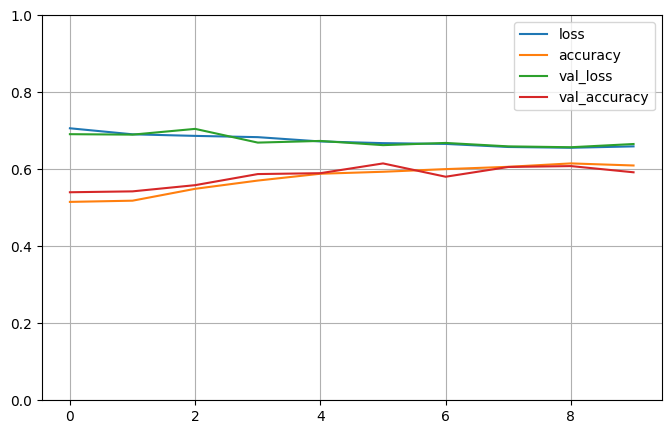

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.2.2.model



Testing # 2 2
2023-04-06 20:04:38.474385
2023-04-06 20:04:38.474429
PREDICT
2023-04-06 20:04:38.688829
Test 1:0 452:416 52.07%
Predict 1:0 596:272 68.66%
Test sizes (868, 4998) (868,)
Distrib of scores: 0.5168026 mean 0.10805316 std
Range of scores: 0.13656345 to 0.6723083
Score threshold 0.5
Confusion matrix
 [[167 249]
 [105 347]]
Normalized matrix
 [[0.19239631 0.28686636]
 [0.12096774 0.39976959]]
Correct scores pos:neg 7 68
Wrong scores pos:neg 4 27


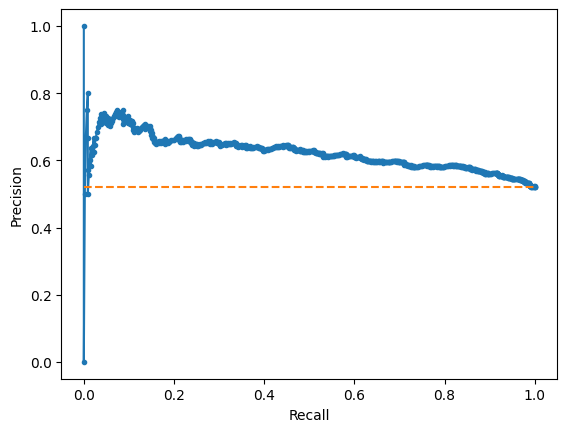

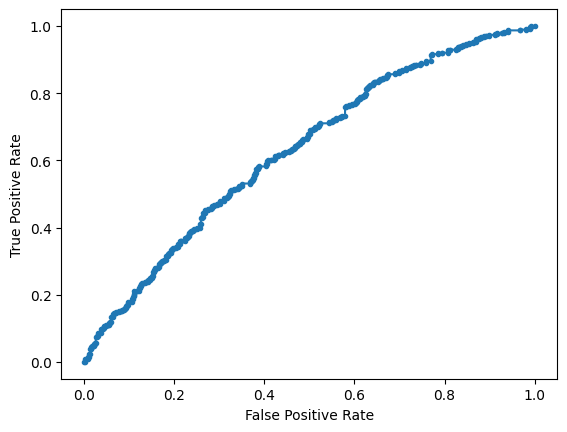

Accuracy: 59.22% Precision: 58.22% Recall: 76.77%
F1: 66.22% MCC: 0.1822
AUPRC: 62.24% AUROC: 62.96%
 accuracy [59.21658986175116]
 precision [58.22147651006711]
 recall [76.76991150442478]
 F1 [66.22137404580153]
 MCC [0.18216220734092733]
 AUPRC [62.23577703137511]
 AUROC [62.95577348536418]

Training # 2 3
2023-04-06 20:04:39.493716
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 20:04:40.359190
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 20:04:41.569686


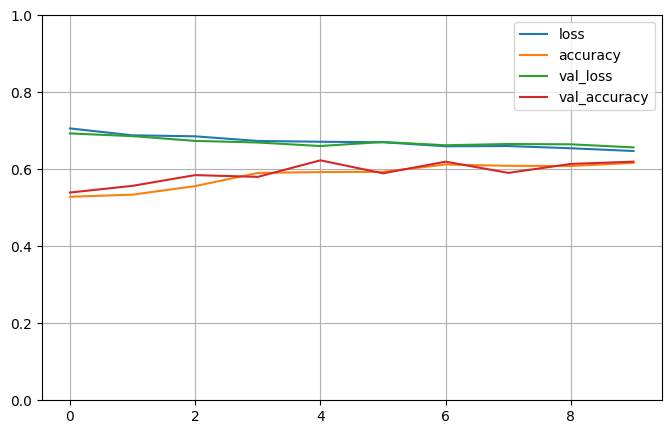

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.2.3.model



Testing # 2 3
2023-04-06 20:05:00.542376
2023-04-06 20:05:00.542467
PREDICT
2023-04-06 20:05:00.760017
Test 1:0 453:407 52.67%
Predict 1:0 570:290 66.28%
Test sizes (860, 4998) (860,)
Distrib of scores: 0.5300825 mean 0.15154676 std
Range of scores: 0.061398305 to 0.73743385
Score threshold 0.5
Confusion matrix
 [[185 222]
 [105 348]]
Normalized matrix
 [[0.21511628 0.25813953]
 [0.12209302 0.40465116]]
Correct scores pos:neg 143 88
Wrong scores pos:neg 72 42


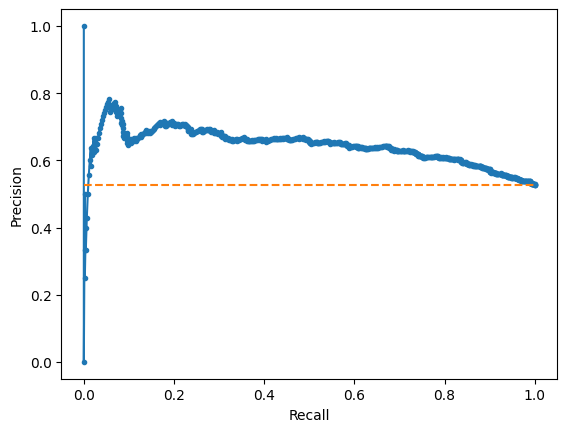

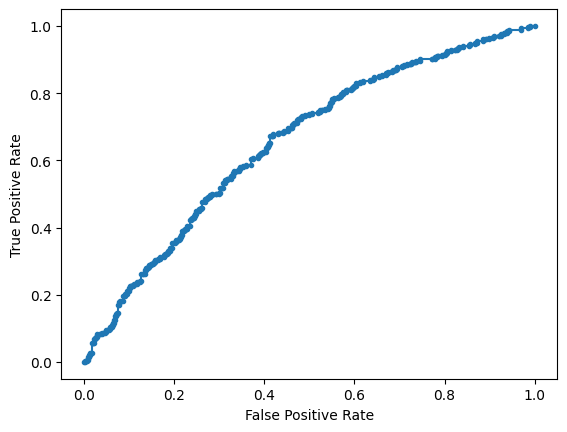

Accuracy: 61.98% Precision: 61.05% Recall: 76.82%
F1: 68.04% MCC: 0.2353
AUPRC: 64.23% AUROC: 65.39%
 accuracy [61.9767441860465]
 precision [61.05263157894737]
 recall [76.82119205298014]
 F1 [68.03519061583579]
 MCC [0.2352566835709368]
 AUPRC [64.22925800788582]
 AUROC [65.39206274305613]

Training # 2 4
2023-04-06 20:05:01.752919
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 20:05:02.594038
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 20:05:04.467483


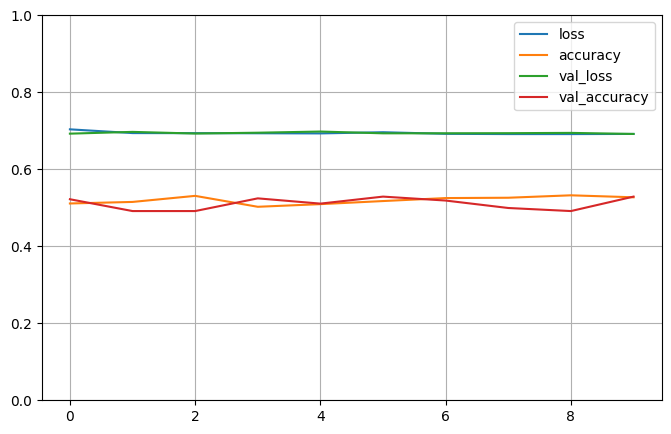

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.2.4.model



Testing # 2 4
2023-04-06 20:05:23.257195
2023-04-06 20:05:23.257238
PREDICT
2023-04-06 20:05:23.474043
Test 1:0 432:447 49.15%
Predict 1:0 696:183 79.18%
Test sizes (879, 4998) (879,)
Distrib of scores: 0.50773305 mean 0.011876624 std
Range of scores: 0.48664662 to 0.54292935
Score threshold 0.5
Confusion matrix
 [[108 339]
 [ 75 357]]
Normalized matrix
 [[0.12286689 0.38566553]
 [0.08532423 0.40614334]]
Correct scores pos:neg 0 0
Wrong scores pos:neg 0 0


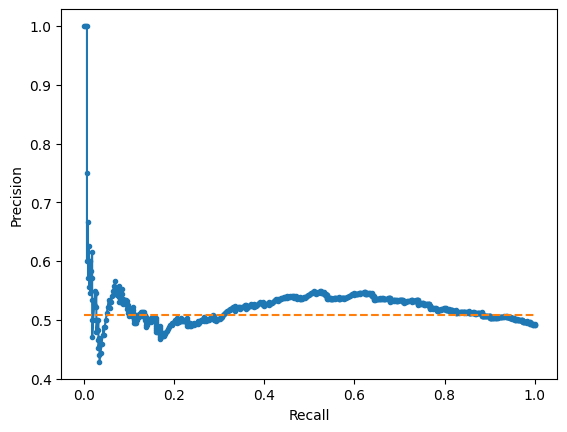

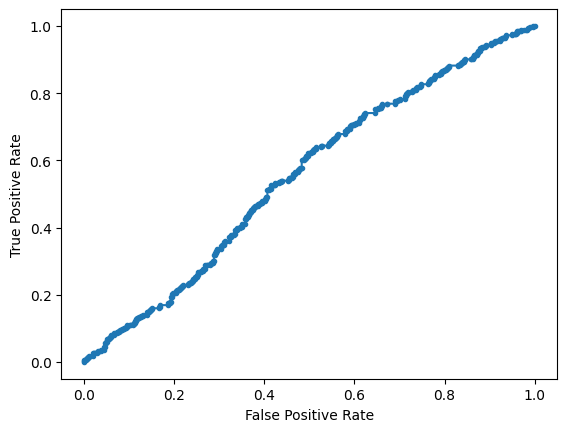

Accuracy: 52.90% Precision: 51.29% Recall: 82.64%
F1: 63.30% MCC: 0.0837
AUPRC: 52.30% AUROC: 55.38%
 accuracy [52.901023890784984]
 precision [51.293103448275865]
 recall [82.63888888888889]
 F1 [63.297872340425535]
 MCC [0.08372824760034973]
 AUPRC [52.298895629571604]
 AUROC [55.38285069185517]

Training # 2 5
2023-04-06 20:05:24.137221
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 20:05:24.968886
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 20:05:26.770469


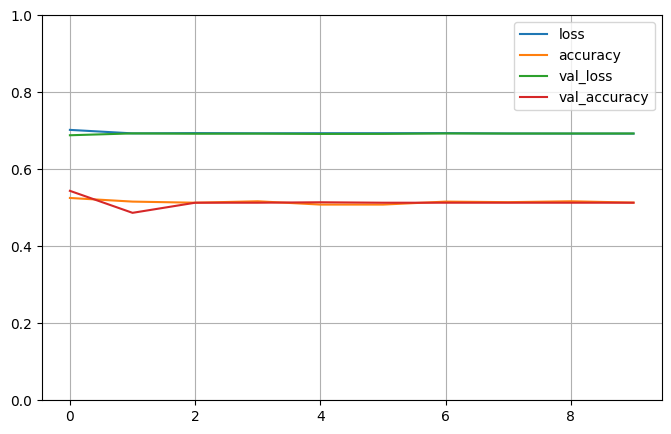

Model saved to /content/drive/My Drive/data/Localization/Models/ CNN_277.2.5.model



Testing # 2 5
2023-04-06 20:05:50.300750
2023-04-06 20:05:50.300795
PREDICT
2023-04-06 20:05:50.530149
Test 1:0 449:426 51.31%
Predict 1:0 875:0 100.00%
Test sizes (875, 4998) (875,)
Distrib of scores: 0.52098536 mean 1.842843e-05 std
Range of scores: 0.5208618 to 0.52099645
Score threshold 0.5
Confusion matrix
 [[  0 426]
 [  0 449]]
Normalized matrix
 [[0.         0.48685714]
 [0.         0.51314286]]
Correct scores pos:neg 0 0
Wrong scores pos:neg 0 0


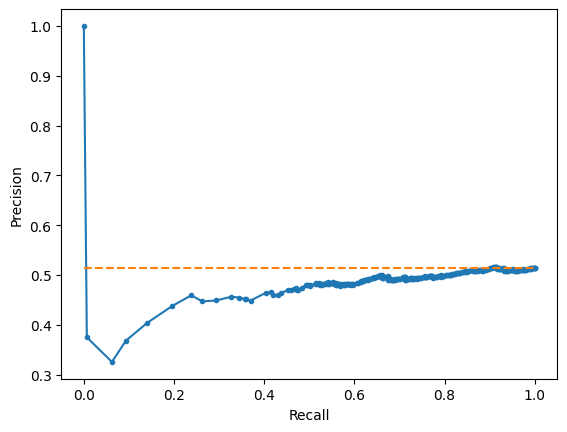

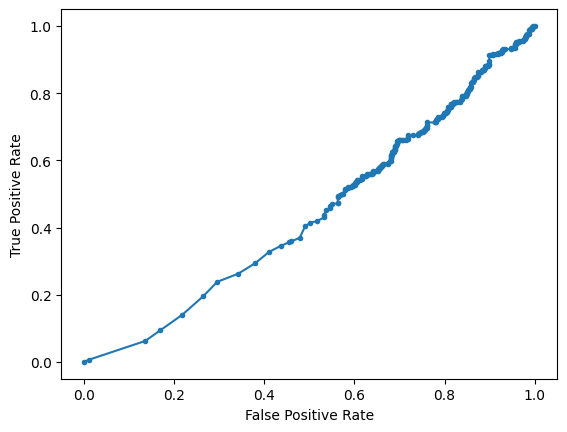

Accuracy: 51.31% Precision: 51.31% Recall: 100.00%
F1: 67.82% MCC: 0.0000
AUPRC: 46.41% AUROC: 44.05%
 accuracy [51.31428571428571]
 precision [51.31428571428571]
 recall [100.0]
 F1 [67.82477341389728]
 MCC [0.0]
 AUPRC [46.406366847041205]
 AUROC [44.05434089316896]
2023-04-06 20:05:51.178712


In [33]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
# allids,allseq = loader.load_spectra(filepath)  # for MLP
allids,allseq = loader.load_sequence(filepath)  # for CNN and RNN
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        filename = f"CNN_277.{show_r}.{show_f}.model"
        cvdo.save_model(filename)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [34]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.27% std 3.96
 precision mean 58.71% std 4.24
 recall mean 76.96% std 11.94
 F1 mean 65.91% std 3.22
 MCC mean 0.1853 std 0.0824
 AUPRC mean 61.15% std 6.61
 AUROC mean 61.90% std 7.12
 accuracy [[62.06896551724138], [62.44343891402715], [59.246171967020025], [61.01123595505618], [62.10045662100456], [60.42841037204059], [59.21658986175116], [61.9767441860465], [52.901023890784984], [51.31428571428571]]
 precision [[59.60960960960961], [61.224489795918366], [58.72727272727273], [64.35897435897436], [60.434056761268785], [60.86175942549371], [58.22147651006711], [61.05263157894737], [51.293103448275865], [51.31428571428571]]
 recall [[86.68122270742357], [67.87330316742081], [73.07692307692307], [54.68409586056645], [79.21225382932167], [71.82203389830508], [76.76991150442478], [76.82119205298014], [82.63888888888889], [100.0]]
 F1 [[70.6405693950178], [64.37768240343348], [65.12096774193549], [59.12838633686691], [68.56060606060606], [65.88921282798833], [66.2213740458